In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
original_test_data = test_data.copy()

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many 
luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
print(train_data.isnull().sum())
print('-'*40)
print(test_data.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
----------------------------------------
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [7]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
train_data.describe(include=['O', 'bool'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall,True
freq,1,4602,5439,8,5915,8291,2,4378


In [9]:
print(train_data.Transported.value_counts(dropna=False))

Transported
True     4378
False    4315
Name: count, dtype: int64


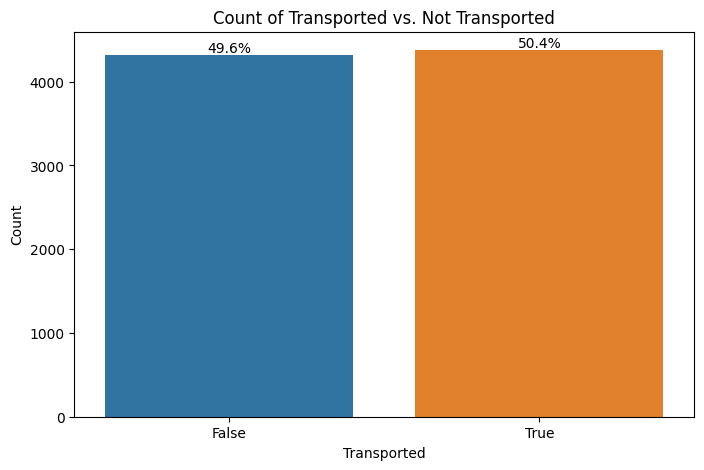

In [10]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Transported', data=train_data)

# Calculating percentages
total = len(train_data)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height, f'{percentage:.1f}%', ha='center', va='bottom')

plt.title('Count of Transported vs. Not Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

The target is highly balanced, so we luckily don't have to consider techniques like under/over-sampling.

In [11]:
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

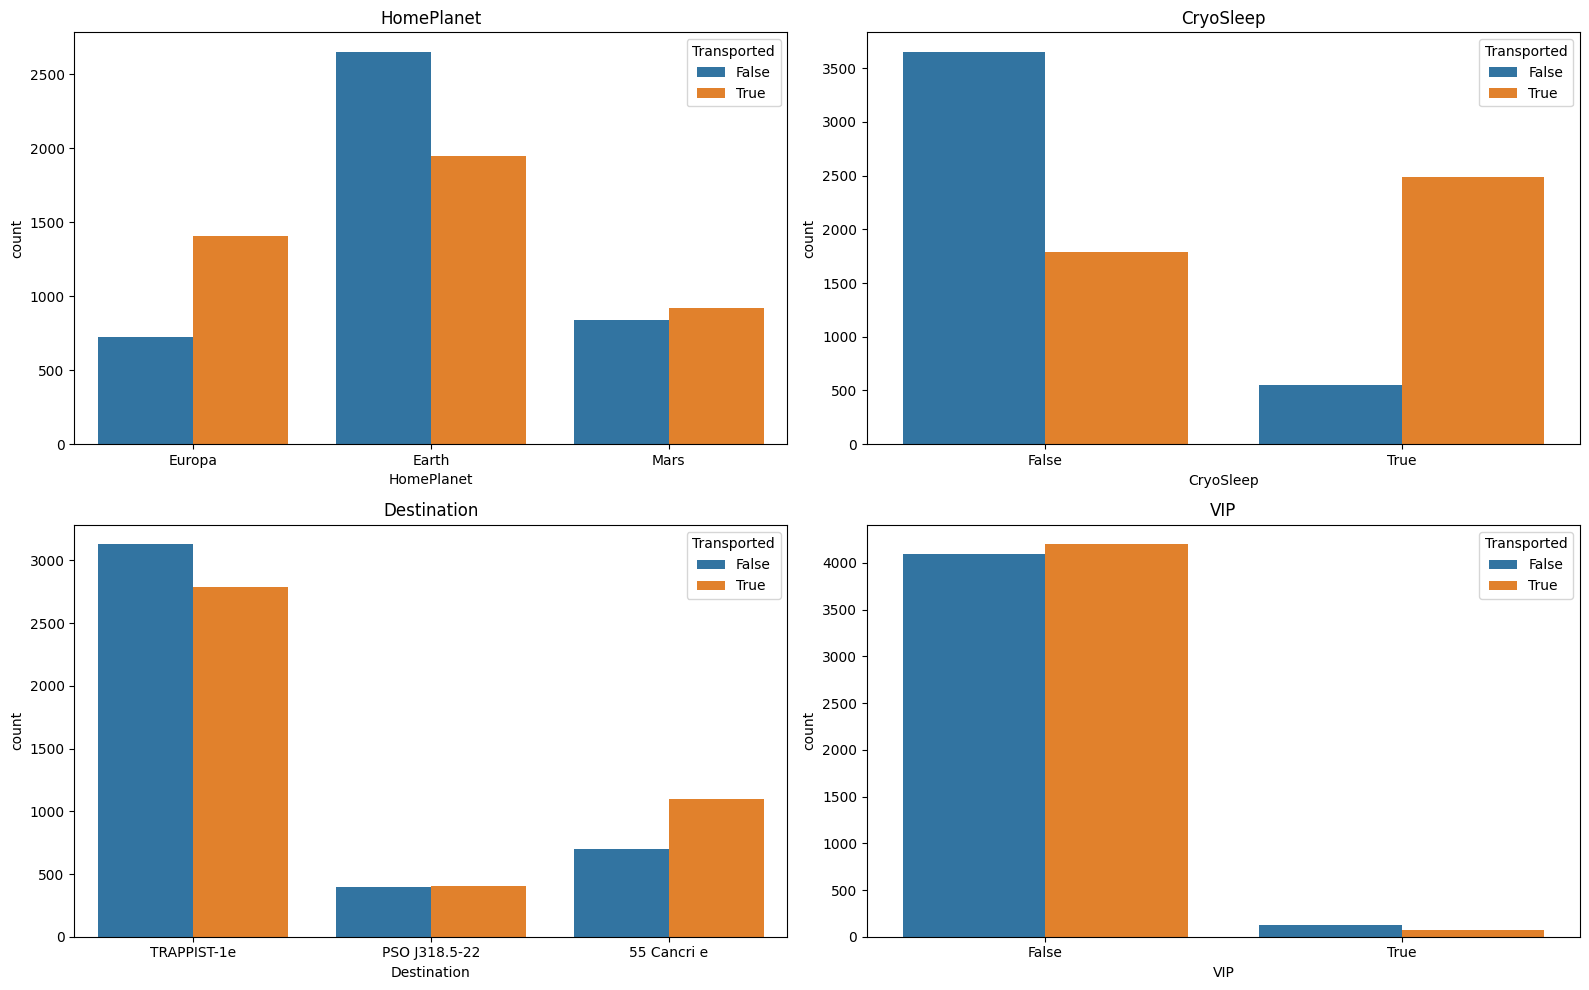

In [12]:
plt.figure(figsize=(16,10))
for i, cat in enumerate(categorical_columns,1):
    ax = plt.subplot(2, 2, i)
    sns.countplot(data=train_data, x=cat, hue='Transported', axes=ax)
    ax.set_title(cat)
plt.tight_layout()
plt.show()

Notes:

- VIP does not appear to be a useful feature; the target split is more or less equal.
- CryoSleep appears the be a very useful feature in contrast.

Insights:

- We might consider dropping the VIP column to prevent overfitting.

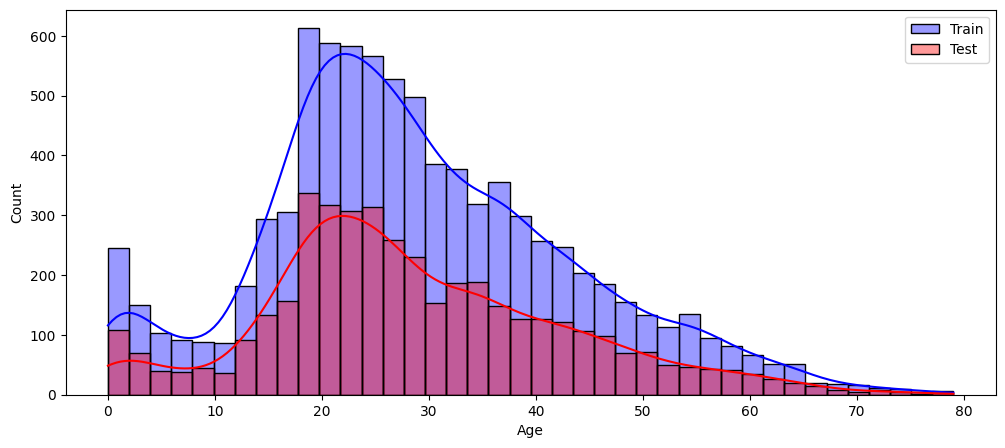

In [13]:
plt.figure(figsize=(12,5))
# Plot histograms for Train data using the Blues palette
sns.histplot(train_data, bins=40, x='Age', color='blue', kde=True, alpha=0.4, label='Train')

# Plot histograms for Test data using the Reds palette
sns.histplot(test_data, bins=40, x='Age', color='red', kde=True, alpha=0.4, label='Test')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Notes:

- 0-18 year olds were more likely to be transported than not.
- 18-25 year olds were less likely to be transported than not.
- Over 25 year olds were about equally likely to be transported than not.

Insight:

- Create a new feature that indicates whether the passanger is a child, adolescent or adult.

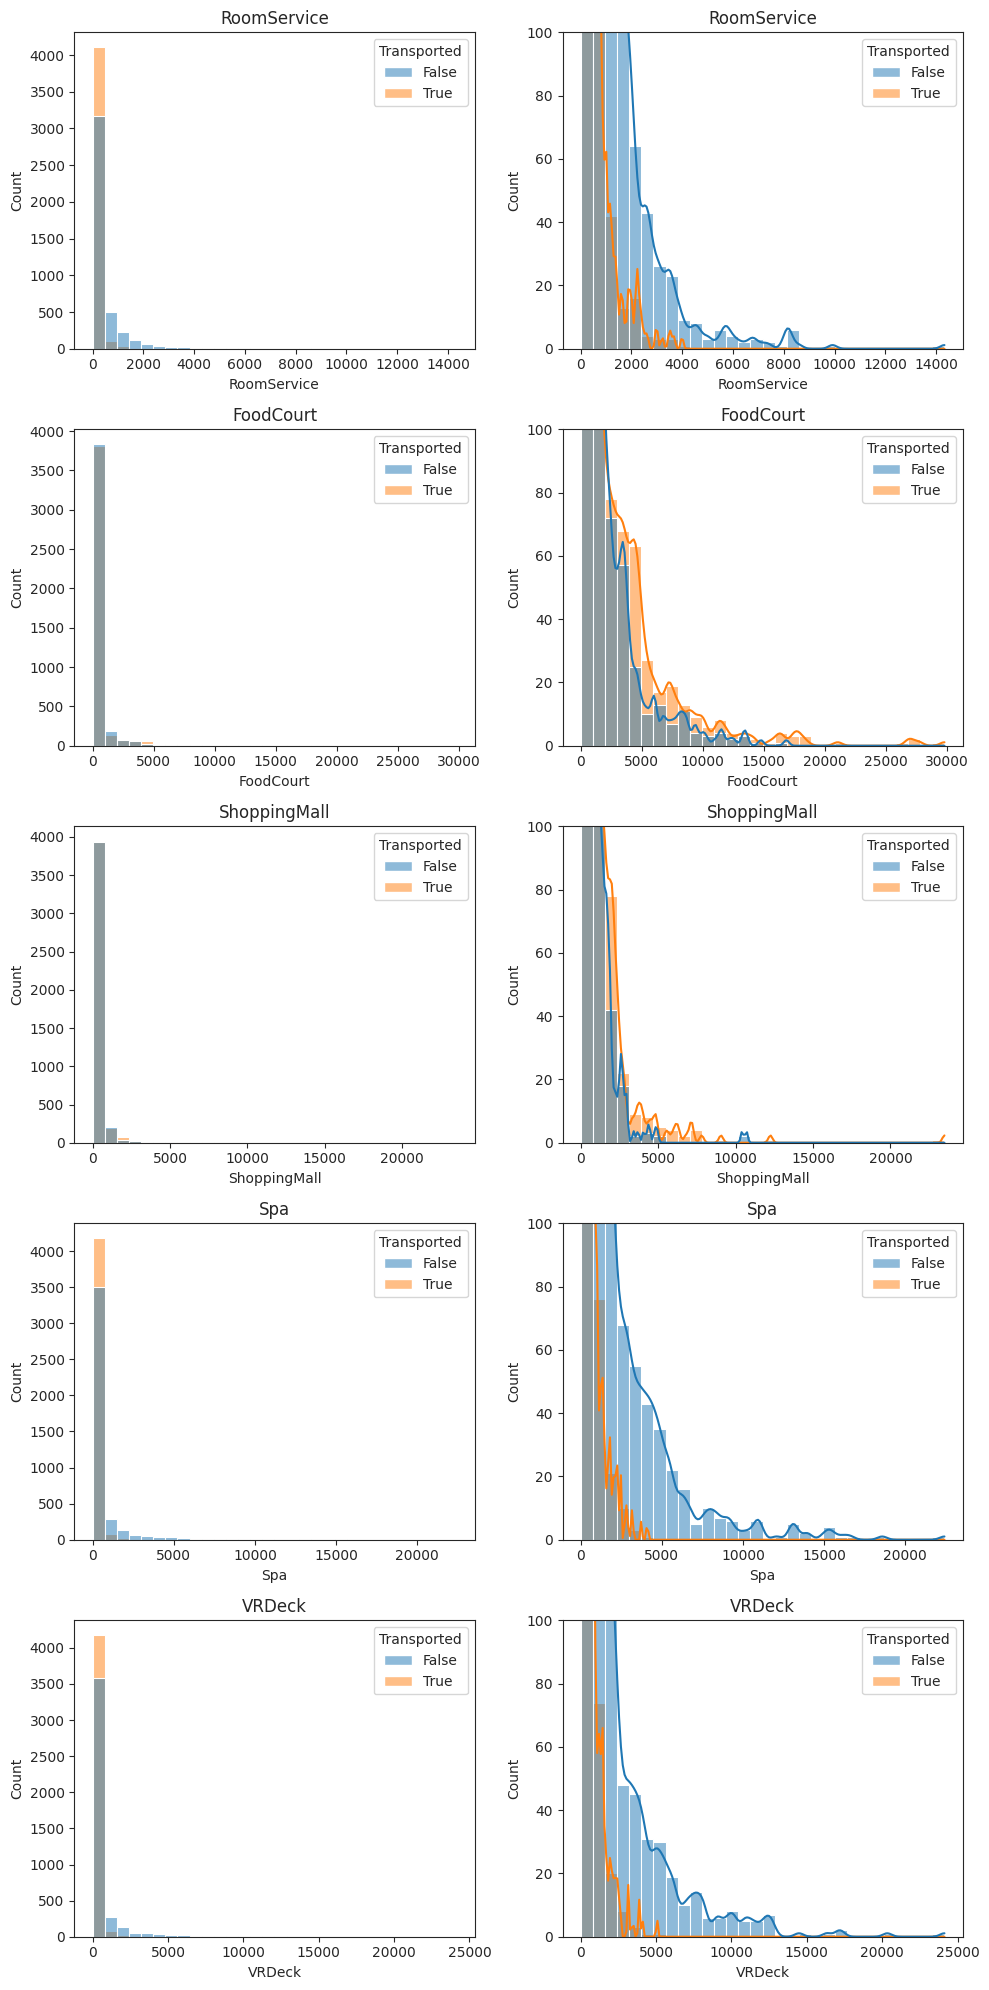

In [14]:
plt.figure(figsize=(10,20))
sns.set_style('ticks')
for i, var in enumerate(spending_columns):
    ax=plt.subplot(5,2,2*i+1)
    sns.histplot(data=train_data, x=var, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var)
    
    ax = plt.subplot(5,2,2*i+2)
    sns.histplot(data=train_data,x=var,axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var)
plt.tight_layout()
plt.show()

Notes:

- Most people don't spend any money (as we can see on the left).
- The distribution of spending decays exponentially (as we can see on the right).
- There are a small number of outliers.
- People who were transported tended to spend less.
- RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall - we can think of this as luxury vs essential amenities.

Insight:

- Create a new feature that tracks the total expenditure across all 5 amenities.
- Create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).
- Take the log transform to reduce skew.

In [15]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train_data[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


Notes:

- PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
- Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Insights:

- We can extract the group and group size from the PassengerId feature.
- We can extract the deck, number and side from the cabin feature.
- We could extract the surname from the name feature to identify families.

In [16]:
# New features - training set
train_data['Cabin'].fillna('Z/9999/Z', inplace=True)

train_data['Deck'] = train_data['Cabin'].apply(lambda x: x.split('/')[0])
train_data['Num'] = train_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train_data['Side'] = train_data['Cabin'].apply(lambda x: x.split('/')[2])

# New features - training set
test_data['Cabin'].fillna('Z/9999/Z', inplace=True)

test_data['Deck'] = test_data['Cabin'].apply(lambda x: x.split('/')[0])
test_data['Num'] = test_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_data['Side'] = test_data['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train_data.loc[train_data['Deck']=='Z', 'Deck']=np.nan
train_data.loc[train_data['Num']==9999, 'Num']=np.nan
train_data.loc[train_data['Side']=='Z', 'Side']=np.nan
test_data.loc[test_data['Deck']=='Z', 'Deck']=np.nan
test_data.loc[test_data['Num']==9999, 'Num']=np.nan
test_data.loc[test_data['Side']=='Z', 'Side']=np.nan


In [17]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S


In [18]:
train_data['Group'] = train_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
train_data['Group_size'] = train_data['Group'].map(train_data['Group'].value_counts())

test_data['Group'] = test_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_data['Group_size'] = test_data['Group'].map(train_data['Group'].value_counts())

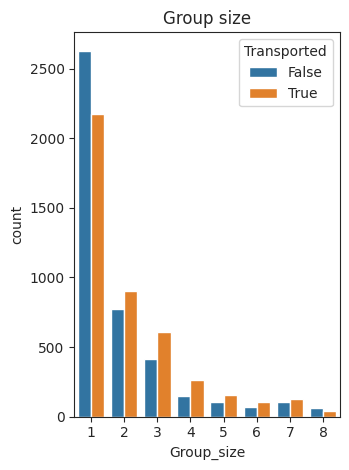

In [19]:
plt.subplot(1,2,2)
sns.countplot(data=train_data, x='Group_size', hue='Transported')
plt.title('Group size')
plt.tight_layout()
plt.show()

In [20]:
train_data['Alone'] = (train_data['Group_size']==1).astype(int)
test_data['Alone'] = (test_data['Group_size']==1).astype(int)

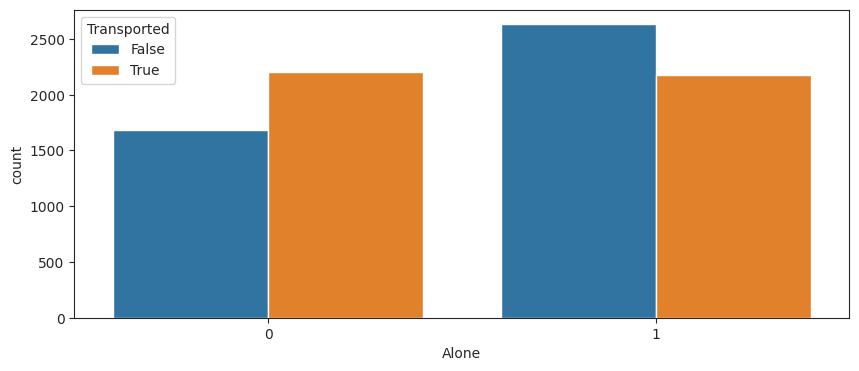

In [21]:
plt.figure(figsize=(10,4))
sns.countplot(data=train_data, x='Alone', hue='Transported')
plt.show()

In [22]:
train_data.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Group,Group_size,Alone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,1,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,2,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,3,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,3,2,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,4,1,1
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,F,0.0,P,5,1,1
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,F,2.0,S,6,2,0
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,G,0.0,S,6,2,0
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,F,3.0,S,7,1,1
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,B,1.0,P,8,3,0


In [23]:
train_data['VIP'] = train_data['VIP'].map({False:0, True:1})
test_data['VIP'] = test_data['VIP'].map({False:0, True:1})

In [24]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Group,Group_size,Alone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,1,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,2,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,3,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,3,2,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,4,1,1


In [25]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_data['TotalSpending'] = train_data[spending_cols].sum(axis=1)
test_data['TotalSpending'] = test_data[spending_cols].sum(axis=1)


In [26]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Num,Side,Group,Group_size,Alone,TotalSpending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,B,0.0,P,1,1,1,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,...,44.0,Juanna Vines,True,F,0.0,S,2,1,1,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,...,49.0,Altark Susent,False,A,0.0,S,3,2,0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,...,193.0,Solam Susent,False,A,0.0,S,3,2,0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,...,2.0,Willy Santantines,True,F,1.0,S,4,1,1,1091.0


In [27]:
train_data['NoSpending'] = (train_data['TotalSpending']==0).astype(int)
test_data['NoSpending'] = (test_data['TotalSpending']==0).astype(int)

In [28]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,Deck,Num,Side,Group,Group_size,Alone,TotalSpending,NoSpending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,...,Maham Ofracculy,False,B,0.0,P,1,1,1,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,...,Juanna Vines,True,F,0.0,S,2,1,1,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,...,Altark Susent,False,A,0.0,S,3,2,0,10383.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,...,Solam Susent,False,A,0.0,S,3,2,0,5176.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,...,Willy Santantines,True,F,1.0,S,4,1,1,1091.0,0


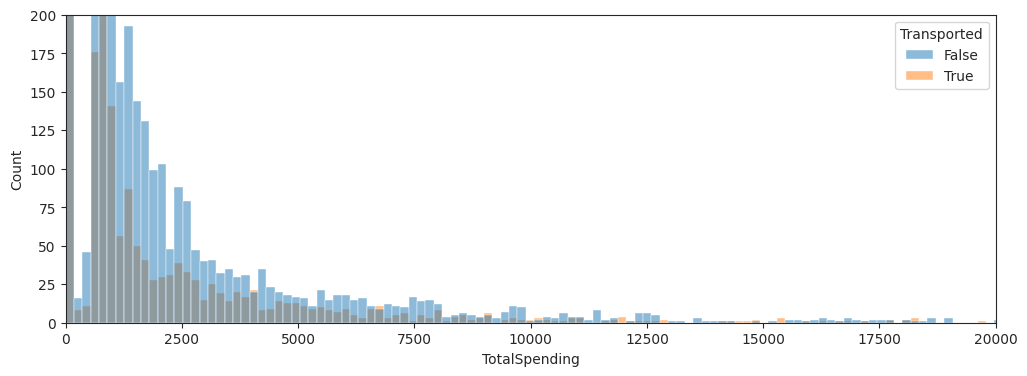

In [29]:
# sns.countplot(data=train_data,x='NoSpending', hue='Transported')
plt.figure(figsize=(12,4))
sns.histplot(data=train_data, x='TotalSpending', hue='Transported', bins=200)
plt.ylim([0,200])
plt.xlim([0,20000])
plt.show()

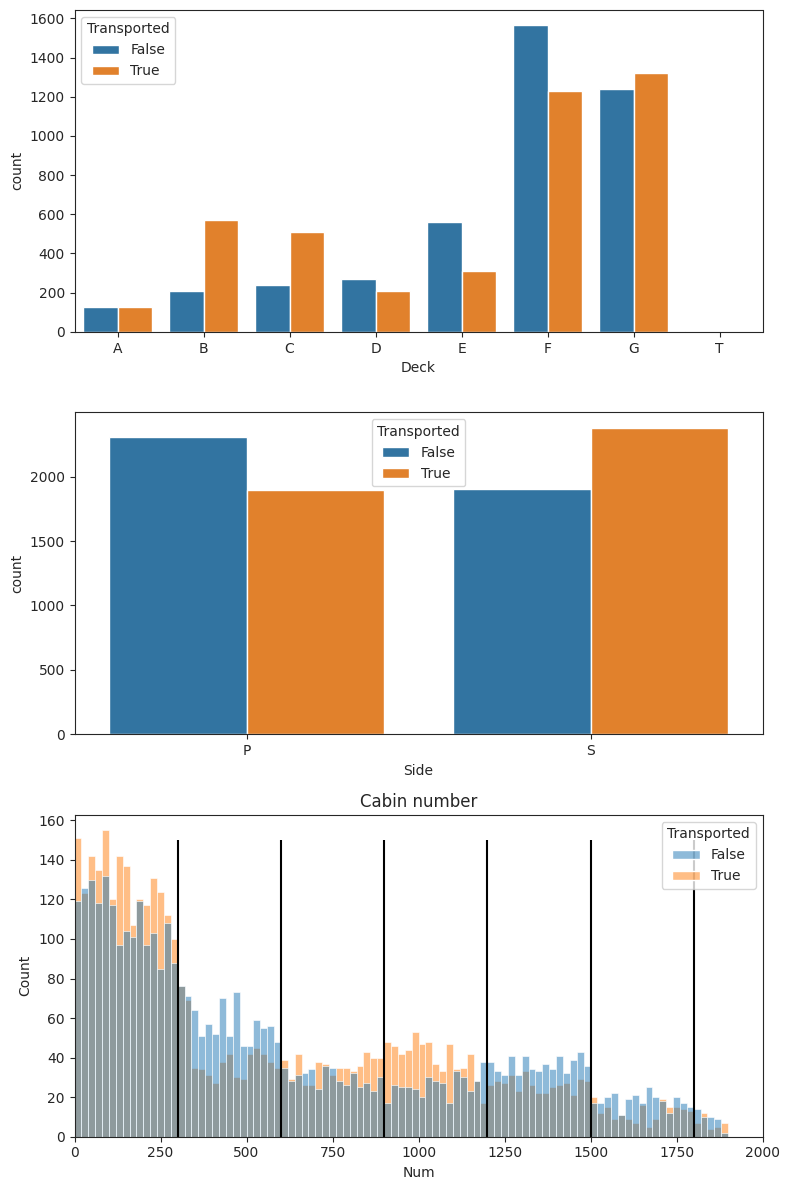

In [30]:
plt.figure(figsize=(8,12))

plt.subplot(3,1,1)
sns.countplot(data=train_data, x='Deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])

plt.subplot(3,1,2)
sns.countplot(data=train_data, x='Side', hue='Transported')

plt.subplot(3,1,3)
sns.histplot(data=train_data, x='Num', hue='Transported',binwidth=20)
plt.title('Cabin number')
plt.vlines(x=300,ymin=0,ymax=150, colors='black')
plt.vlines(x=600,ymin=0,ymax=150, colors='black')
plt.vlines(x=900,ymin=0,ymax=150, colors='black')
plt.vlines(x=1200,ymin=0,ymax=150, colors='black')
plt.vlines(x=1500,ymin=0,ymax=150, colors='black')
plt.vlines(x=1800,ymin=0,ymax=150, colors='black')
plt.xlim([0,2000])
plt.tight_layout()


plt.show()

In [31]:
train_data['Num_Group'] = pd.cut(train_data['Num'], 
                                      bins=[0, 300, 600, 900, 1200, 1500, 1800, float('inf')], 
                                      labels=[0, 1, 2, 3, 4, 5, 6],
                                      right=False)
test_data['Num_Group'] = pd.cut(test_data['Num'], 
                                      bins=[0, 300, 600, 900, 1200, 1500, 1800, float('inf')], 
                                      labels=[0, 1, 2, 3, 4, 5, 6],
                                      right=False)

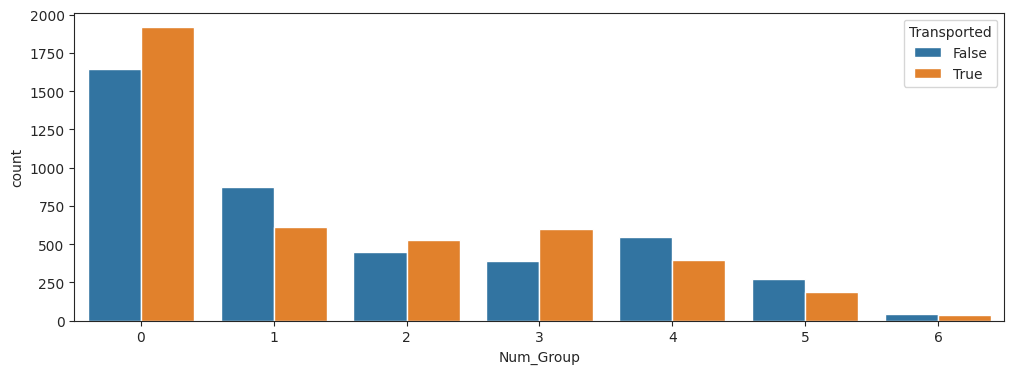

In [32]:
# sns.countplot(data=train_data,x='NoSpending', hue='Transported')
plt.figure(figsize=(12,4))
sns.countplot(data=train_data, x='Num_Group', hue='Transported')
plt.show()

In [33]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Deck,Num,Side,Group,Group_size,Alone,TotalSpending,NoSpending,Num_Group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,...,False,B,0.0,P,1,1,1,0.0,1,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,...,True,F,0.0,S,2,1,1,736.0,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,...,False,A,0.0,S,3,2,0,10383.0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,...,False,A,0.0,S,3,2,0,5176.0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,...,True,F,1.0,S,4,1,1,1091.0,0,0


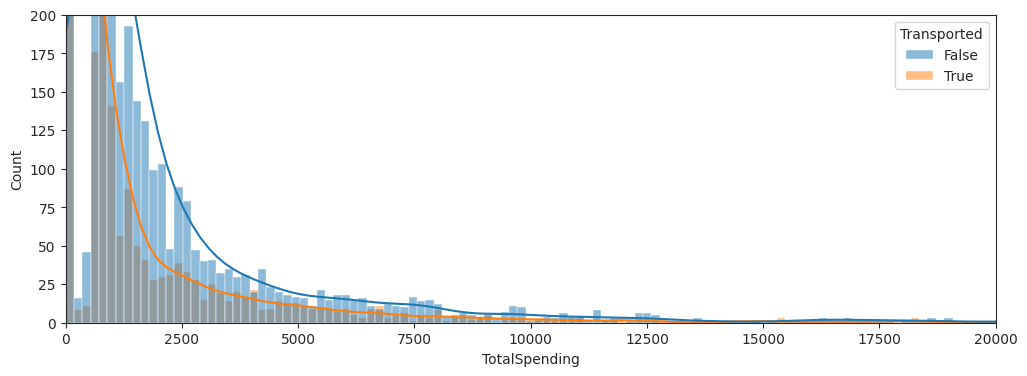

In [34]:
# sns.countplot(data=train_data,x='NoSpending', hue='Transported')
plt.figure(figsize=(12,4))
sns.histplot(data=train_data, x='TotalSpending', hue='Transported', bins=200, kde=True)
plt.ylim([0,200])
plt.xlim([0,20000])
plt.show()

In [35]:
print(train_data.columns)
train_data.head()

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Deck', 'Num', 'Side', 'Group', 'Group_size',
       'Alone', 'TotalSpending', 'NoSpending', 'Num_Group'],
      dtype='object')


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Deck,Num,Side,Group,Group_size,Alone,TotalSpending,NoSpending,Num_Group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,...,False,B,0.0,P,1,1,1,0.0,1,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,...,True,F,0.0,S,2,1,1,736.0,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,...,False,A,0.0,S,3,2,0,10383.0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,...,False,A,0.0,S,3,2,0,5176.0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,...,True,F,1.0,S,4,1,1,1091.0,0,0


Text(0.5, 1.0, 'Heatmap of missing values')

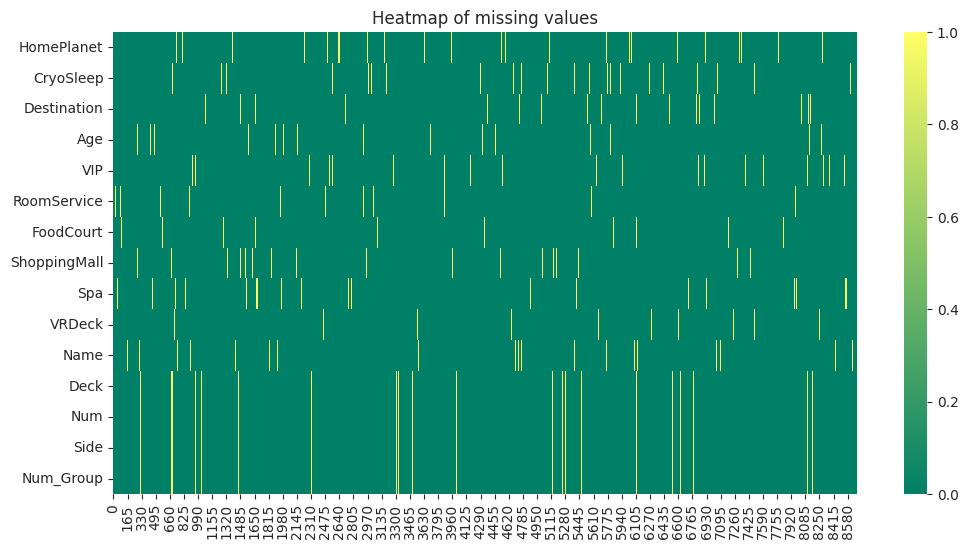

In [36]:
na_cols=train_data.columns[train_data.isna().any()].tolist()
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train_data[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

Notes:

- Missing values are independent of the target and for the most part are isolated.
- Even though only 2% of the data is missing, about 25% of all passengers have at least 1 missing value.
- PassengerId is the only (original) feature to not have any missing values.

Insight:

- Since most of the missing values are isolated it makes sense to try to fill these in as opposed to just dropping rows.
- If there is a relationship between PassengerId and other features we can fill missing values according to this column.

In [37]:
# drop_cols = ['PassengerId', 'Cabin', 'Group', 'Num', 'Name']
# train_data = train_data.drop(drop_cols, axis=1)
# test_data = test_data.drop(drop_cols, axis=1)

In [38]:
# Columns with missing values
na_cols=train_data.columns[train_data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(train_data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(train_data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


Strategy

The easiest way to deal with missing values is to just use the median for continuous features and the mode for categorical features (see version 20 of this notebook). This will work 'well enough' but if we want to maximise the accuracy of our models then we need to look for patterns within the missing data. The way to do this is by looking at the joint distribution of features, e.g. do passengers from the same group tend to come from the same family? There are obviously many combinations so we will just summarise the useful trends I and others have found.

In [39]:
# Replace NaN's with outliers for now (so we can split feature)
train_data['Name'].fillna('Unknown Unknown', inplace=True)
test_data['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train_data['Surname']=train_data['Name'].str.split().str[-1]
test_data['Surname']=test_data['Name'].str.split().str[-1]

In [40]:
data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

In [41]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Group
1       1
2       1
3       1
4       1
5       1
       ..
9276    1
9277    1
9278    1
9279    1
9280    1
Length: 9124, dtype: int64


Text(0.5, 1.0, 'Number of unique home planets per group')

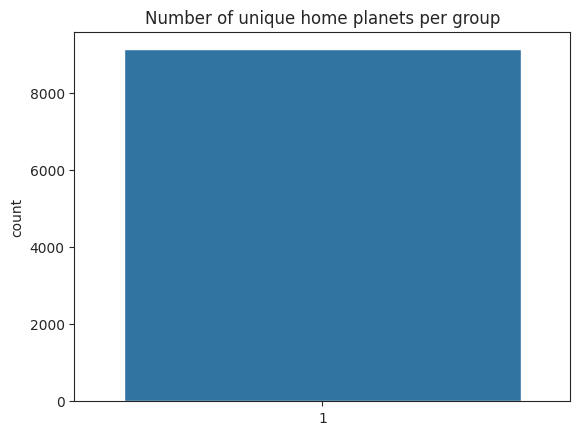

In [42]:
# Countplot of unique values
unique_home_planets = (GHP_gb > 0).sum(axis=1)
print(unique_home_planets)
sns.countplot(x=unique_home_planets)
plt.title('Number of unique home planets per group')

Great! This shows that everyone in the same group comes from the same home planet. So we can fill the missing HomePlanet values according to the group. (At least the ones where the group size is bigger than 1.)

In [43]:
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

In [44]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


<Axes: xlabel='Deck', ylabel='HomePlanet'>

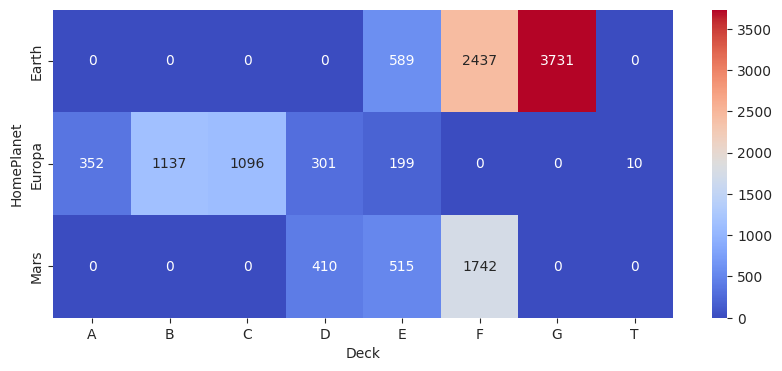

In [45]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [46]:
# Missing values before
HP_before = data['HomePlanet'].isna().sum()

# Decks A, B, C, T are all from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G is from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'G'), 'HomePlanet'] = 'Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_before)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


In [47]:
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)


In [48]:
HP_bef = data['HomePlanet'].isna().sum()

SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)]

In [49]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 5


In [50]:
# Only 5 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2631,2817_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


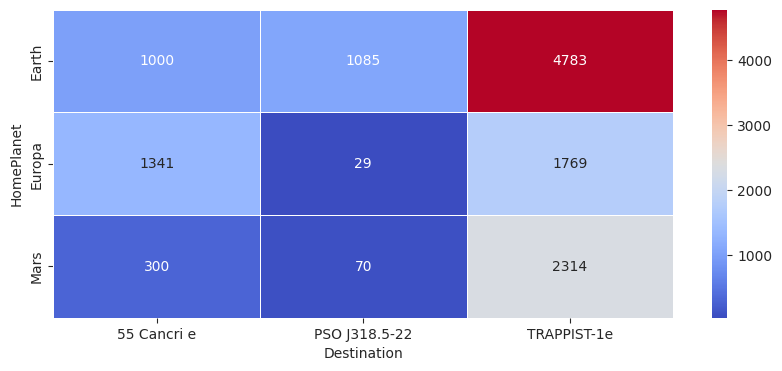

<Axes: xlabel='Deck', ylabel='HomePlanet'>

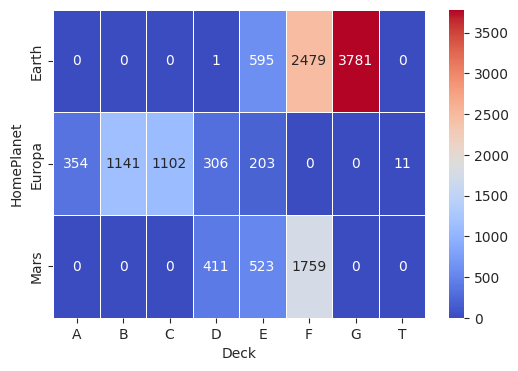

In [51]:
HPD_gb=data.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)
# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(data=HPD_gb, annot=True, fmt='g', cmap='coolwarm', linewidth=.5)
plt.show()
HPDeck_gb = data.groupby(['HomePlanet', 'Deck'])['Deck'].size().unstack().fillna(0)
plt.figure(figsize=(6,4))
sns.heatmap(data=HPDeck_gb, cmap='coolwarm', annot=True, fmt='g', linewidth=.5)

Most people traveling to TRAPPIST are from Earth, however, only people from Decks E, F, G are from Earth.|

In [52]:
# Fill remaining HomePlanet missing values with Earth or Mars
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['E', 'F', 'G'])), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['A', 'B', 'C', 'D', 'T'])), 'HomePlanet']='Mars'
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values after: 0


In [53]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(train_data),2)
mv

,Number_missing,Percentage_missing
CryoSleep,310,3.57
Destination,274,3.15
Age,270,3.11
VIP,296,3.41
RoomService,263,3.03
FoodCourt,289,3.32
ShoppingMall,306,3.52
Spa,284,3.27
VRDeck,268,3.08
Transported,4277,49.20


In [54]:
# Missing values before
D_bef=data['Destination'].isna().sum()
print('#Destination missing values before:',D_bef)
data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'
print('#Destination missing values after:',data['Destination'].isnull().sum())

#Destination missing values before: 274
#Destination missing values after: 0


In [55]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['NoSpending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


In [56]:
# Missing values before
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

E_bef=data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


In [57]:
imputer1 = SimpleImputer(strategy="most_frequent")     ##To fill Categorical Features.
imputer2 = SimpleImputer(strategy="median")            ##To fill numeircal features.

In [58]:
cat_cols = data.select_dtypes(include=["object","bool", 'category']).columns.tolist()
cat_cols.remove("Transported")
num_cols = data.select_dtypes(include=["int","float"]).columns.tolist()

In [59]:
print(cat_cols)
print(num_cols)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Name', 'Deck', 'Side', 'Num_Group', 'Surname']
['Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'Group', 'Group_size', 'Alone', 'TotalSpending', 'NoSpending']


In [60]:
data[cat_cols] = imputer1.fit_transform(data[cat_cols])
data[num_cols] = imputer2.fit_transform(data[num_cols])

In [61]:
data.columns
data = data.drop(['VIP', 'Name', 'Cabin', 'Group', 'Surname'], axis=1)

In [62]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Group_size,Alone,TotalSpending,NoSpending,Num_Group
0,0001_01,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1.0,1.0,0.0,1.0,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,1.0,1.0,736.0,0.0,0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,2.0,0.0,10383.0,0.0,0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,2.0,0.0,5176.0,0.0,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,1.0,1.0,1091.0,0.0,0


In [63]:
data.isnull().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported      4277
Deck                0
Num                 0
Side                0
Group_size          0
Alone               0
TotalSpending       0
NoSpending          0
Num_Group           0
dtype: int64

In [64]:
# Train and test
X=data[data['PassengerId'].isin(train_data['PassengerId'].values)].copy()
test_data=data[data['PassengerId'].isin(original_test_data['PassengerId'].values)].copy()

In [65]:
y = X['Transported'].copy().astype(int)
X = X.drop(['Transported', 'PassengerId'], axis=1)
test_data = test_data.drop('PassengerId', axis=1)

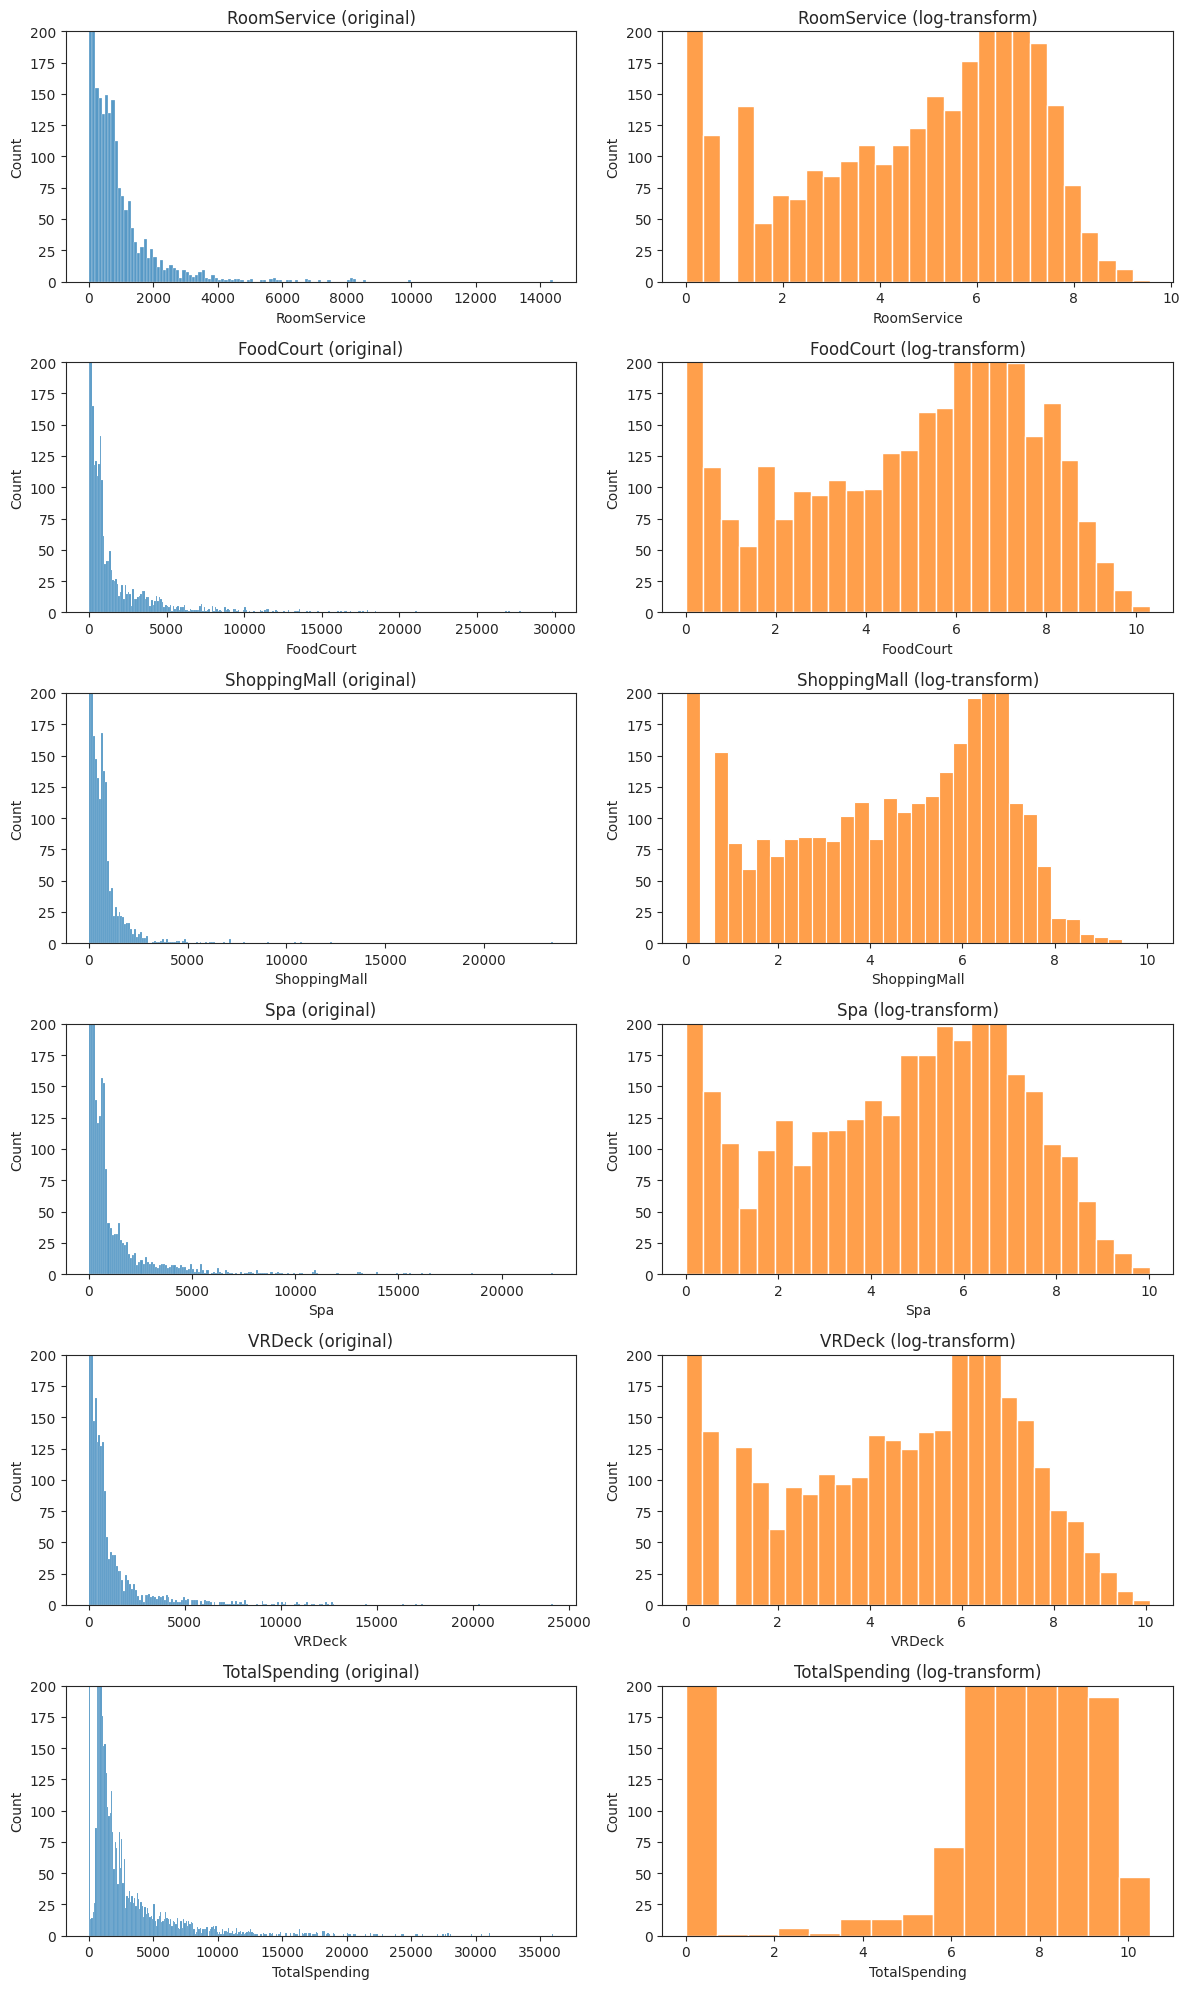

In [66]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpending']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [67]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpending']:
    X[col]=np.log(1+X[col])
    test_data[col]=np.log(1+test_data[col])

In [68]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype in ["object", 'category']]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
test_data = ct.transform(test_data)

# Print new shape
print('Training set shape:', X.shape)
print("Test set shape", test_data.shape)

Training set shape: (8693, 34)
Test set shape (4277, 34)


In [69]:
# Train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
training_score=[]
testing_score=[]
def model_prediction(model):
    model.fit(X_train, y_train)
    x_train_pred = model.predict(X_train)
    x_test_pred = model.predict(X_test)
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test,x_test_pred))
    print(f"Recall Score of {model} model is:",recall_score(y_test,x_test_pred))
    print(f"F1 Score of {model} model is:",f1_score(y_test,x_test_pred))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()

Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 95.17513736263736
Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, de

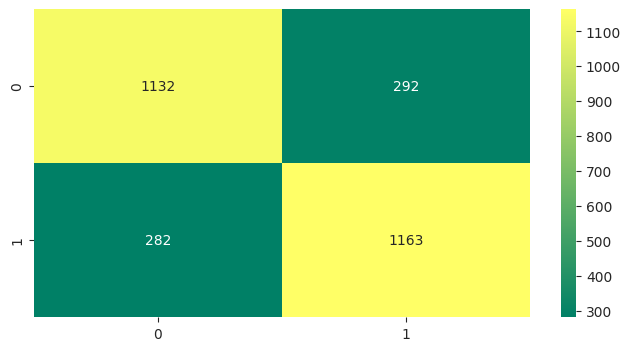

In [71]:
model = XGBClassifier()
model_prediction(XGBClassifier())

In [72]:
# Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 10],
#     'n_estimators': [100, 200],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)
# Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


# Evaluate on the test set
# best_model = XGBClassifier({'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8})
# y_pred = best_model.predict(X_test)
# print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [73]:
best_model = XGBClassifier(colsample_bytree=0.8,learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8)
best_model.fit(X_train, y_train)
predictions = best_model.predict(test_data)

In [74]:
output = pd.DataFrame({'PassengerId':original_test_data.PassengerId, 'Transported':predictions.astype(bool)})

In [75]:
output.to_csv('submission.csv', index=False)